In [58]:
!pip install tensorflow pandas matplotlib scikit-learn keras

In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [60]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        # Configura para evitar alocar toda memória da GPU
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU configurada para uso com memory growth.")
    except RuntimeError as e:
        print(e)
else:
    print("GPU não encontrada, rodando na CPU.")

GPU configurada para uso com memory growth.


In [61]:
# Carregar dataset
data = np.load('/content/pssm_dataset.npz', allow_pickle=True)
X, y, weights = data['X'], data['y'], data['weights']

print("Shapes ->", X.shape, y.shape, weights.shape)

Shapes -> (126, 754, 20) (126, 754, 3) (126, 754)


In [62]:
# Split
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp, w_train, w_temp = train_test_split(X, y, weights, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test, w_val, w_test = train_test_split(X_temp, y_temp, w_temp, test_size=0.5, random_state=42)

In [78]:
# Modelo CNN
model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    Conv1D(64, 5, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(32, activation='tanh'),
    Dropout(0.3),

    Dense(3, activation='softmax')  # Previsão por resíduo
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 754, 64)        │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 754, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 754, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 754, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 754, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 754, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 754, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 754, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 754, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 754, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 754, 3)         │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,371 (165.51 KB)

 Trainable params: 41,987 (164.01 KB)

 Non-trainable params: 384 (1.50 KB)

In [79]:
# Treinamento com máscara
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(
    X_train, y_train,
    sample_weight=w_train,
    validation_data=(X_val, y_val, w_val),
    epochs=30, batch_size=16,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 818ms/step - accuracy: 0.2738 - loss: 0.3343 - val_accuracy: 0.1068 - val_loss: 0.2050 - learning_rate: 0.0010
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2847 - loss: 0.2858 - val_accuracy: 0.1180 - val_loss: 0.1990 - learning_rate: 0.0010
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2953 - loss: 0.2757 - val_accuracy: 0.1235 - val_loss: 0.1943 - learning_rate: 0.0010
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3012 - loss: 0.2743 - val_accuracy: 0.1255 - val_loss: 0.1879 - learning_rate: 0.0010
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3086 - loss: 0.2547 - val_accuracy: 0.1280 - val_loss: 0.1828 - learning_rate: 0.0010
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3202 - loss: 0.2439 - val_accuracy: 0.1303 - val_loss: 0.1788 - learning_rate: 0.0010
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3300 - loss: 0.2384 - val_accuracy: 0.131

In [80]:
# Avaliação
pred = model.predict(X_test)
q3 = np.mean(np.argmax(pred[w_test==1], axis=1) == np.argmax(y_test[w_test==1], axis=1))
print(f"Q3 Score: {q3:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
Q3 Score: 0.7157


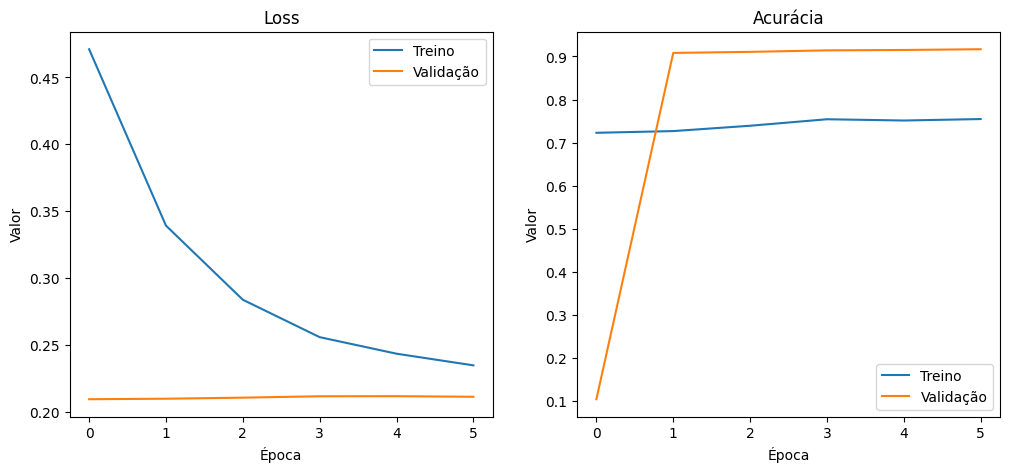

In [66]:
# Curvas de treino e validação
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.legend()

plt.show()


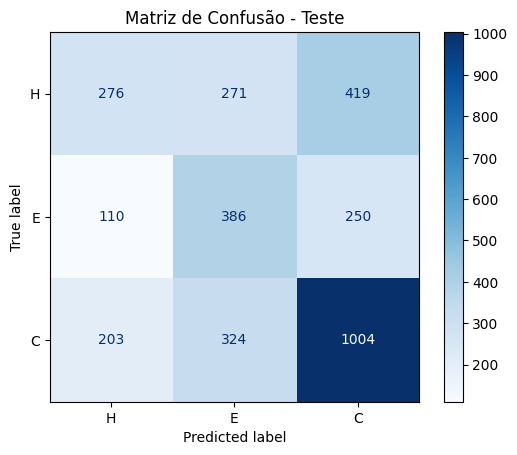

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Converter para classes
true_labels = np.argmax(y_test[w_test==1], axis=1)
pred_labels = np.argmax(pred[w_test==1], axis=1)

# Matriz de confusão
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['H', 'E', 'C'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Teste")
plt.show()


In [68]:
# Escolher índice de sequência no teste
seq_idx = 0

# Predição para essa sequência
pred_seq = np.argmax(pred[seq_idx], axis=1)
true_seq = np.argmax(y_test[seq_idx], axis=1)

# Mapear para letras
mapping = {0: 'H', 1: 'E', 2: 'C'}
true_str = ''.join([mapping[i] for i in true_seq])
pred_str = ''.join([mapping[i] for i in pred_seq])

print("Estrutura real:\n", true_str)
print("\nEstrutura prevista:\n", pred_str)


Estrutura real:
 CCCCCCCCCECCEEECCEEECCCCEEEEEECCCCCHHHHHHHHHHHHHHHHHHHCCCCCCCEEEECCCCHHHHHHHCCCCCCCHHHHHHHHHHCEEEECCCCCCCCCCCCCHHHHHHHHCCCCEEEEEEECCCCCCCCCCCHHHCEEEEEEECCCCHHHCCEECCCCHHHHHHHHHHHHCCCCCCCCCCCCCCEECCCCCHHHHHHHHHHHHHHHHHCCCCEEEEEECCCCCCCCHHHHHHHHHHHHHHHHCCEECCCCCCEEEECCCCCCEEEEEEEEHHHHHHHHHHCHHHCCEEEECHHHHHHHHHHHHHHCCCCCCCEEEEECCCCEEEEECCCCCCCCCCCCCCCCHHHHHHHHHHHHHHCCHHHHHHHHHHHHHHHHCCEECHHHHCCCCCCEECCHHHHHHHHHHCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH

Estrutura prevista:
 HHCECCCCCHEEEHCCCHCECCCCCEEEEECCCCECCHHEHCCEEECHHHHCCCHCCCCECEECEEEECCHECCCCCCCCEECCCCHHECCCCCEEEHCHCECCCCCHECCCCHECCCCHEEEEHECECHEHHCHCHCCCCCCCCEHEECCHCCCCCEECCHHEHCCCHHHCCEHHCCCCHCHHCCCCCCCCECECHCECCCECCH

In [69]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, pred_labels, target_names=['H', 'E', 'C']))


              precision    recall  f1-score   support

           H       0.47      0.29      0.35       966
           E       0.39      0.52      0.45       746
           C       0.60      0.66      0.63      1531

    accuracy                           0.51      3243
   macro avg       0.49      0.49      0.48      3243
weighted avg       0.51      0.51      0.50      3243

